In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
import numpy as np
import umap
from sentence_transformers.util import cos_sim


In [5]:
base_prompts_1 = 'Why do humans need sleep?'
base_prompts_2 = 'How does photosynthesis work in plants?'
base_prompts_3 = 'Describe happiness without using the word "happy".'

In [15]:
variant_prompts_1 = [
    'What makes sleep essential for humans?',
    'How does sleep benefit the human body and mind?',
    'What role does sleep play in human health and functioning?',
    'Why is it necessary for people to sleep?',
    'In what ways is sleep crucial to human well-being?',
    "What are the reasons humans can't function without sleep?",
    "Why is getting enough sleep important for humans?",
    "What happens to the human body and brain that makes sleep a necessity?"
]

In [8]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [17]:
base_p1_emb = model.encode(base_prompts_1)

In [18]:
variants_p1_emb = model.encode(varient_prompts_1)

In [19]:
similarities = util.cos_sim(base_p1_emb, varients_p1_emb).cpu().numpy().flatten()
print(b_v_p1_sim)

tensor([[0.8500, 0.7480, 0.6935, 0.9188, 0.7535, 0.8178, 0.8823, 0.8255]])


In [27]:
def filter_v_sim(base,variant,model, min_sim=0.85):
    base_emb = model.encode(base, convert_to_tensor=True)
    var_embs = model.encode(variant, convert_to_tensor=True)
    sims = util.cos_sim(base_emb, var_embs).cpu().numpy().flatten()

    df = pd.DataFrame({
        "variant": variant,
        "similarity": sims,
        "keep": [(min_sim <= s) for s in sims]
    })
    return df.sort_values("similarity", ascending=False)

    filtered_df = filter_variants_by_similarity(
    base_prompt_1, variant_prompts_1, model, min_sim=0.85)

    print(filtered_df)

In [28]:
filter_v_sim(base_prompts_1,variant_prompts_1,model)

,variant,similarity,keep
3,Why is it necessary for people to sleep?,0.918821,True
6,Why is getting enough sleep important for humans?,0.882275,True
0,What makes sleep essential for humans?,0.850024,True
7,What happens to the human body and brain that ...,0.825465,False
5,What are the reasons humans can't function wit...,0.817788,False
4,In what ways is sleep crucial to human well-be...,0.753535,False
1,How does sleep benefit the human body and mind?,0.747996,False
2,What role does sleep play in human health and ...,0.693460,False


In [2]:
from openai import OpenAI

Response 1:
Short answer: because sleep performs several essential housekeeping and control functions the body and brain can’t do as well while awake — it restores, consolidates, clears waste, regulates hormones and immunity, and supports learning and emotional balance.

Key reasons we need sleep
- Brain restoration and waste clearance: during deep sleep the brain’s interstitial space increases and the glymphatic system clears metabolic waste (including proteins such as beta‑amyloid and tau). That helps maintain healthy brain function over time.
- Memory and learning: sleep (different stages for different types of memory) replays and consolidates memories formed during the day, stabilizing and integrating new information and skills.
- Synaptic homeostasis: sleep helps “downscale” or renormalize synaptic connections that build up during wakefulness so the brain remains efficient and ready to learn again.
- Physical repair and growth: many repair processes (cellular repair, tissue growth

c:\Users\daneb\Documents\GitHub\LLMagic\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\daneb\Documents\GitHub\LLMagic\.venv\lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


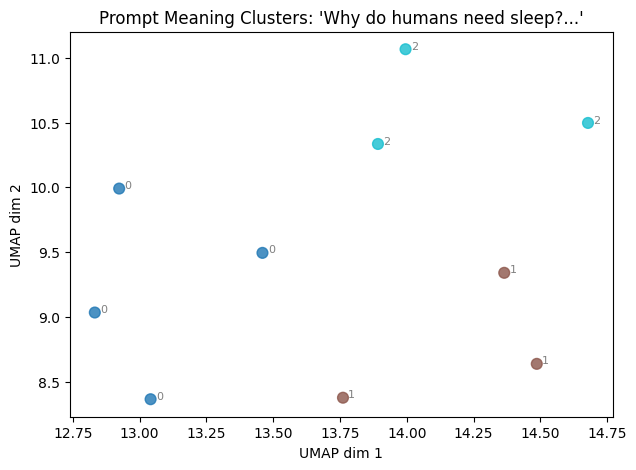

In [ ]:
client = OpenAI(
  api_key="API_KEY"
)

n_runs = 10

model_name1 = 'gpt-5-mini'
responses_1 = []
n_clusters = 3

for i in range(n_runs):
    response = client.chat.completions.create(
        model=model_name1,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": base_prompts_1}
        ],
    )
    text = response.choices[0].message.content.strip()
    responses_1.append(text)
    print(f"Response {i+1}:\n{text}\n{'-'*60}")

embs = model.encode(responses_1)

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(embs)

centroids = kmeans.cluster_centers_

for cluster_id in range(n_clusters):
    cluster_responses = [r for i, r in enumerate(responses_1) if labels[i] == cluster_id]
    print(f"\n🌀 Cluster {cluster_id} — {len(cluster_responses)} responses")
    print("-"*60)
    for r in cluster_responses:
        print("•", r[:200].replace("\n", " "), "...")
    print()


reducer = umap.UMAP(random_state=42)
emb_2d = reducer.fit_transform(embs)

plt.figure(figsize=(7, 5))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap="tab10", s=60, alpha=0.8)
for i, txt in enumerate(range(len(responses_1))):
    plt.text(emb_2d[i, 0]+0.02, emb_2d[i, 1], f"{labels[i]}", fontsize=8, color="gray")
plt.title(f"Prompt Meaning Clusters: '{base_prompts_1[:30]}...'")
plt.xlabel("UMAP dim 1")
plt.ylabel("UMAP dim 2")
plt.show()



In [13]:
responses_1

['Short answer: because sleep performs several essential housekeeping and control functions the body and brain can’t do as well while awake — it restores, consolidates, clears waste, regulates hormones and immunity, and supports learning and emotional balance.\n\nKey reasons we need sleep\n- Brain restoration and waste clearance: during deep sleep the brain’s interstitial space increases and the glymphatic system clears metabolic waste (including proteins such as beta‑amyloid and tau). That helps maintain healthy brain function over time.\n- Memory and learning: sleep (different stages for different types of memory) replays and consolidates memories formed during the day, stabilizing and integrating new information and skills.\n- Synaptic homeostasis: sleep helps “downscale” or renormalize synaptic connections that build up during wakefulness so the brain remains efficient and ready to learn again.\n- Physical repair and growth: many repair processes (cellular repair, tissue growth, re

In [15]:
def cluster_coherence(embs, labels, cluster_id):
    cluster_embs = embs[labels == cluster_id]
    if len(cluster_embs) < 2:
        return 0
    sims = cos_sim(cluster_embs, cluster_embs)
    upper = np.triu_indices_from(sims, k=1)
    return sims[upper].mean().item()

In [16]:
coherences = [cluster_coherence(np.array(embs), labels, i) for i in range(n_clusters)]

In [17]:
base_cluster_id = int(np.argmax(coherences))
base_centroid = centroids[base_cluster_id]

In [18]:
print(f"Most Consistent Cluster: {base_cluster_id}")
print(f"Average internal similarity: {coherences[base_cluster_id]:.3f}")

Most Consistent Cluster: 0
Average internal similarity: 0.936


In [19]:
base_cluster_embs = np.array([embs[i] for i in range(len(embs)) if labels[i] == base_cluster_id])

base_response_centroid = np.mean(base_cluster_embs, axis=0)

In [21]:
print(f"Base response centroid shape: {base_response_centroid.shape}")

Base response centroid shape: (384,)
